<a href="https://colab.research.google.com/github/supehungay/AI-For-Beginners/blob/main/Gemini_2_0_func_calling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://storage.googleapis.com/mle-courses-prod/users/61b6fa1ba83a7e37c8309756/private-files/01b97e90-b846-11ef-99fc-e9ac20f73f15-RAGGraph___Neo4J___CamelAI__8_.png)

Tác giả: [ProtonX Team](https://protonx.io/courses/674042a55b4afc001a04fa65)

### Ý nghĩa và cách hoạt động của flow lựa chọn hàm:

1. **Ý nghĩa:**
   - Mô hình Gemini API sử dụng danh sách hàm được định nghĩa trước để phân tích câu hỏi của người dùng.
   - Dựa vào mô tả và tham số của từng hàm, mô hình sẽ quyết định chọn hàm nào phù hợp nhất để trả lời.

2. **Cách hoạt động:**
   - Người dùng đặt câu hỏi (e.g., "Thời tiết ở San Francisco ngày mai thế nào?").
   - Mô hình đối chiếu câu hỏi với danh sách hàm:
     - Nếu câu hỏi liên quan đến thời tiết, mô hình chọn hàm `check_weather`.
     - Nếu câu hỏi liên quan đến tìm nhà hàng, mô hình chọn hàm `find_restaurants`.
   - Sau khi chọn hàm, mô hình trả về tên hàm và các tham số cần thiết để gọi API.

Flow này đảm bảo mô hình luôn chọn đúng hàm dựa trên ngữ cảnh và yêu cầu của người dùng.

In [ ]:
"""
Install an additional SDK for JSON schema support Google AI Python SDK

$ pip install google.ai.generativelanguage
"""

import os
import google.generativeai as genai
from google.ai.generativelanguage_v1beta.types import content
from google.colab import userdata

genai.configure(api_key=userdata.get("api_key"))

# Create the model
generation_config = {
  "temperature": 1,
  "top_p": 0.95,
  "top_k": 40,
  "max_output_tokens": 8192,
  "response_mime_type": "text/plain",
}

model = genai.GenerativeModel(
  model_name="gemini-2.0-flash-exp",
  generation_config=generation_config,
  system_instruction="You are a helpful assistant integrated with a real-time API. Use the functions provided to answer user queries accurately.",
  tools = [
    genai.protos.Tool(
      function_declarations = [
        genai.protos.FunctionDeclaration(
          name = "check_weather",
          description = "Provides the current weather and forecast for a specified location.",
          parameters = content.Schema(
            type = content.Type.OBJECT,
            enum = [],
            required = ["location", "date"],
            properties = {
              "location": content.Schema(
                type = content.Type.STRING,
              ),
              "date": content.Schema(
                type = content.Type.STRING,
              ),
            },
          ),
        ),
        genai.protos.FunctionDeclaration(
          name = "find_restaurants",
          description = "Finds top-rated restaurants near a specified location.",
          parameters = content.Schema(
            type = content.Type.OBJECT,
            enum = [],
            required = ["location", "cuisine"],
            properties = {
              "location": content.Schema(
                type = content.Type.STRING,
              ),
              "cuisine": content.Schema(
                type = content.Type.STRING,
              ),
              "rating_threshold": content.Schema(
                type = content.Type.INTEGER,
              ),
            },
          ),
        ),
      ],
    ),
  ],
  tool_config={'function_calling_config':'ANY'},
)

chat_session = model.start_chat(
  history=[
    {
      "role": "user",
      "parts": [
        "You are a helpful assistant integrated with a real-time API. Use the functions provided to answer user queries accurately.\n\nUser query: \"What’s the weather in San Francisco tomorrow?\"\n\n",
      ],
    },
    {
      "role": "model",
      "parts": [
        "I need to know the exact date to look up the weather forecast. Could you provide the full date, including the year?\n",
      ],
    },
    {
      "role": "user",
      "parts": [
        "What’s the weather in San Francisco tomorrow?",
      ],
    },
    {
      "role": "model",
      "parts": [
        "I need to know the exact date to look up the weather forecast. Could you provide the full date, including the year?\n",
      ],
    },
    {
      "role": "user",
      "parts": [
        "What’s the weather in San Francisco 12/12/2024?\n",
      ],
    },
    {
      "role": "model",
      "parts": [
        "```Function call\n{\n  \"name\": \"check_weather\",\n  \"args\": {\n    \"location\": \"San Francisco\",\n    \"date\": \"12/12/2024\"\n  }\n}\n```",
      ],
    },
  ]
)



Kiểm tra hàm được gọi

In [ ]:
response = chat_session.send_message("INSERT_INPUT_HERE")

# Print out each of the function calls requested from this single call.
# Note that the function calls are not executed. You need to manually execute the function calls.
# For more see: https://github.com/google-gemini/cookbook/blob/main/quickstarts/Function_calling.ipynb
for part in response.parts:
  if fn := part.function_call:
    args = ", ".join(f"{key}={val}" for key, val in fn.args.items())
    print(f"{fn.name}({args})")

check_weather(date=12/12/2024, location=San Francisco)


Đồ thị của Agents

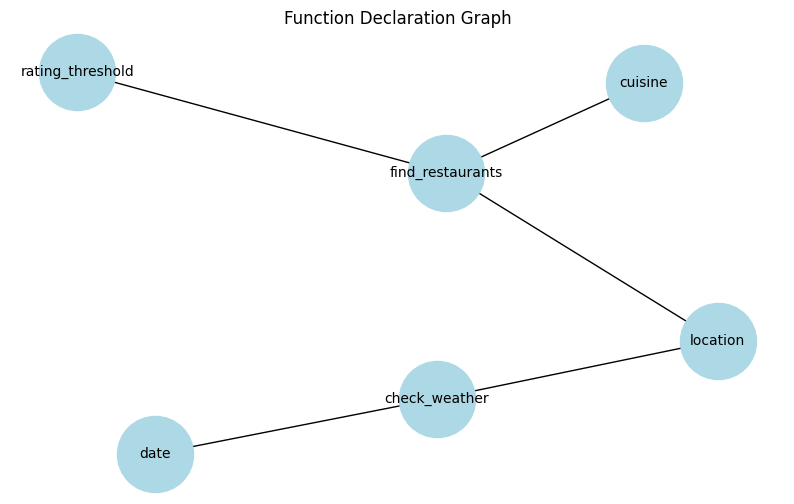

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Define the function declarations
functions = {
    "check_weather": {
        "description": "Provides the current weather and forecast for a specified location.",
        "parameters": {
            "location": "The name of the city or region, e.g., 'San Francisco, CA'.",
            "date": "The date for the forecast, in YYYY-MM-DD format."
        }
    },
    "find_restaurants": {
        "description": "Finds top-rated restaurants near a specified location.",
        "parameters": {
            "location": "The name of the city or region, e.g., 'New York, NY'.",
            "cuisine": "The type of cuisine to search for, e.g., 'Italian', 'Japanese'.",
            "rating_threshold": "The minimum rating (out of 5) for a restaurant."
        }
    }
}

# Create a directed graph
G = nx.DiGraph()

# Add function nodes
for func_name, func_details in functions.items():
    G.add_node(func_name, description=func_details["description"])

    # Add parameter nodes and edges
    for param, desc in func_details["parameters"].items():
        G.add_node(param, description=desc)
        G.add_edge(func_name, param)

# Plot the graph
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(10, 6))

# Draw nodes and labels
nx.draw_networkx_nodes(G, pos, node_size=3000, node_color='lightblue')
nx.draw_networkx_edges(G, pos, arrows=True)
nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')

# Add descriptions as edge labels
edge_labels = nx.get_edge_attributes(G, 'description')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("Function Declaration Graph")
plt.axis("off")
plt.show()
